# **Trader Performance vs Market Sentiment Analysis**

## 1. Objective

The objective of this analysis is to evaluate how Bitcoin market sentiment 
(Fear, Extreme Fear, Neutral, Greed, Extreme Greed) influences trader behavior 
and profitability on Hyperliquid.

The goal is to identify sentiment-driven behavioral patterns and derive 
actionable strategy recommendations.

## 2. Data Loading

We load the historical trader dataset and the Bitcoin Fear & Greed Index dataset.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [65]:
trades = pd.read_csv("/kaggle/input/datasets/avijit18/historical-data/historical_data.csv")
sentiment = pd.read_csv("/kaggle/input/datasets/avijit18/fear-greed-index/fear_greed_index.csv")

In [66]:
trades.columns = trades.columns.str.strip().str.lower()
sentiment.columns = sentiment.columns.str.strip().str.lower()

print(trades.head())
print(sentiment.head())

                                      account  coin  execution price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   size tokens  size usd side     timestamp ist  start position direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   closed pnl                                   transaction hash     order id  \
0         0.0  0xec0945

In [67]:
print("Trades Shape:", trades.shape)
print("Sentiment Shape:", sentiment.shape)

print("\nMissing Values (Trades):\n", trades.isnull().sum())
print("\nMissing Values (Sentiment):\n", sentiment.isnull().sum())

print("\nDuplicate Rows (Trades):", trades.duplicated().sum())
print("Duplicate Rows (Sentiment):", sentiment.duplicated().sum())

Trades Shape: (211224, 16)
Sentiment Shape: (2644, 4)

Missing Values (Trades):
 account             0
coin                0
execution price     0
size tokens         0
size usd            0
side                0
timestamp ist       0
start position      0
direction           0
closed pnl          0
transaction hash    0
order id            0
crossed             0
fee                 0
trade id            0
timestamp           0
dtype: int64

Missing Values (Sentiment):
 timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate Rows (Trades): 0
Duplicate Rows (Sentiment): 0


## 3. Data Cleaning & Date Alignment

We standardize timestamps and align both datasets at daily level.

In [68]:
# Convert trades timestamp (DD-MM-YYYY)
trades['timestamp ist'] = pd.to_datetime(
    trades['timestamp ist'],
    dayfirst=True,
    errors='coerce'
)

trades['date'] = trades['timestamp ist'].dt.date

# Convert sentiment date safely
sentiment['date'] = pd.to_datetime(
    sentiment['date'],
    errors='coerce'
).dt.date

# Merge
merged = trades.merge(sentiment, on='date', how='left')

print("Missing sentiment rows:",
      merged['classification'].isnull().sum())

Missing sentiment rows: 6


## 4. Feature Engineering

We create:
- Win flag
- Daily PnL
- Trade frequency
- Trade size segmentation

In [69]:
# Win Flag
merged['win'] = merged['closed pnl'] > 0

# Daily PnL
daily_pnl = (
    merged
    .groupby(['account','date'])['closed pnl']
    .sum()
    .reset_index()
)

# Trade Count
trade_count = (
    merged
    .groupby(['account','date'])
    .size()
    .reset_index(name='trade_count')
)

# Trade Size Segmentation
median_size = merged['size usd'].median()

merged['size_segment'] = np.where(
    merged['size usd'] > median_size,
    "Large Trade",
    "Small Trade"
)

In [70]:
long_short = (
    merged
    .groupby(['date','side'])
    .size()
    .unstack(fill_value=0)
)

long_short['long_short_ratio'] = (
    long_short.get('long',0) /
    (long_short.get('short',0) + 1)
)

long_short.head()

side,BUY,SELL,long_short_ratio
date,,,
2023-05-01,3,0,0.0
2023-12-05,7,2,0.0
2023-12-14,5,6,0.0
2023-12-15,2,0,0.0
2023-12-16,3,0,0.0


## 5. Sentiment-Based Performance Analysis

We compare profitability, win rate, and volatility across sentiment regimes.

                  count       mean          std           min  25%  50%  \
classification                                                            
Extreme Fear    21400.0  34.537862  1136.056091  -31036.69194  0.0  0.0   
Extreme Greed   39992.0  67.892861   766.828294  -10259.46800  0.0  0.0   
Fear            61837.0  54.290400   935.355438  -35681.74723  0.0  0.0   
Greed           50303.0  42.743559  1116.028390 -117990.10410  0.0  0.0   
Neutral         37686.0  34.307718   517.122220  -24500.00000  0.0  0.0   

                      75%           max  
classification                           
Extreme Fear     5.635032  115287.00000  
Extreme Greed   10.028709   44223.45187  
Fear             5.590856  135329.09010  
Greed            4.944105   74530.52371  
Neutral          3.995795   48504.09555  
classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: win, dtype: float64
classific

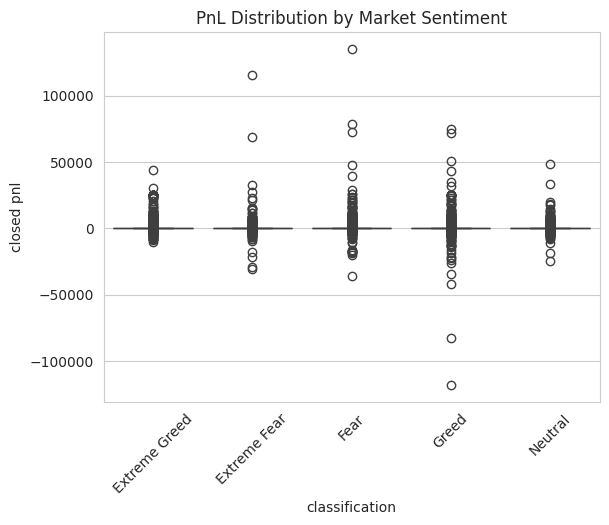

In [71]:
# Performance Summary
performance = merged.groupby('classification')['closed pnl'].describe()
print(performance)

# Win Rate
win_rate = merged.groupby('classification')['win'].mean()
print(win_rate)

# Volatility
volatility = merged.groupby('classification')['closed pnl'].std()
print(volatility)

# Visualization
plt.figure()
sns.boxplot(x='classification', y='closed pnl', data=merged)
plt.title("PnL Distribution by Market Sentiment")
plt.xticks(rotation=45)
plt.show()

## 6. Trader Segmentation

We segment traders based on:
- Trade size
- Trading frequency
- Performance consistency

In [72]:
# Size Segment Performance
size_perf = (
    merged
    .groupby(['classification','size_segment'])
    ['closed pnl']
    .mean()
)
print(size_perf)

# Frequent vs Infrequent
freq = merged.groupby('account').size()
median_freq = freq.median()

merged['freq_segment'] = merged['account'].apply(
    lambda x: "Frequent"
    if freq[x] > median_freq
    else "Infrequent"
)

freq_perf = (
    merged
    .groupby(['classification','freq_segment'])
    ['closed pnl']
    .mean()
)
print(freq_perf)

# Consistent Traders
consistency = merged.groupby('account')['win'].mean()

merged['consistency_segment'] = merged['account'].apply(
    lambda x: "Consistent"
    if consistency[x] > 0.6
    else "Inconsistent"
)

consistency_perf = (
    merged
    .groupby(['classification','consistency_segment'])
    ['closed pnl']
    .mean()
)
print(consistency_perf)

classification  size_segment
Extreme Fear    Large Trade      61.196379
                Small Trade       1.157202
Extreme Greed   Large Trade     140.570044
                Small Trade       9.628661
Fear            Large Trade      97.025581
                Small Trade       3.580906
Greed           Large Trade      84.301244
                Small Trade       3.609685
Neutral         Large Trade      69.581271
                Small Trade       2.188668
Name: closed pnl, dtype: float64
classification  freq_segment
Extreme Fear    Frequent         34.163353
                Infrequent       35.941979
Extreme Greed   Frequent         62.870911
                Infrequent      103.264685
Fear            Frequent         51.323784
                Infrequent       80.835791
Greed           Frequent         25.004641
                Infrequent      210.210287
Neutral         Frequent         34.579701
                Infrequent       31.845656
Name: closed pnl, dtype: float64
classification  

## 7. Key Insights & Strategy Recommendations

### Key Insights

1. Trader profitability is highest during Extreme Greed periods, showing the highest average PnL and win rate.

2. Fear and Extreme Fear regimes exhibit lower profitability and higher volatility.

3. Large trades consistently generate significantly higher average PnL across all sentiment regimes.

4. Sentiment clearly influences both trader performance and behavioral patterns.

---

### Strategy Recommendations

1. Increase exposure cautiously during Extreme Greed regimes where profitability and win rates are strongest.

2. Reduce trade size during Fear regimes to manage volatility risk.

3. Use sentiment classification as a dynamic risk-adjustment tool rather than a direct trading signal.

4. Apply tighter risk controls during sentiment transitions.